# jobflow

[`jobflow`](https://materialsproject.github.io/jobflow/index.html) and [`atomate2`](https://materialsproject.github.io/atomate2/index.html) are key packages of the [Materials Project](https://materialsproject.org/) . `jobflow` was especially designed to simplify the execution of dynamic workflows -- when the actual number of jobs is dynamically determined upon runtime instead of being statically fixed before running the workflow(s). `jobflow`'s overall flexibility allows for building workflows that go beyond the usage in materials science. `jobflow` serves as the basis of `atomate2`, which implements data generation workflows in the context of materials science and will be used for data generation in the Materials Project in the future.  

## Installation / Setup
`jobflow` can be installed via `pip install` and directly run with the default setup. It will then internally rely on a memory database as defined in the software package [`maggma`](https://materialsproject.github.io/maggma/). For large-scale usage, a [MongoDB](https://www.mongodb.com/)-like database might be specified in a jobflow.yaml file.
A high-throughput setup (i.e., parallel execution of independent parts in the workflow) of `jobflow` can be achieved using additional packages like [`fireworks`](https://materialsproject.github.io/fireworks/) or [`jobflow-remote`](https://matgenix.github.io/jobflow-remote/). Both packages require a MongoDB database. In case of `FireWorks`, however, the MongoDB database needs to be directly connected to the compute nodes. `jobflow-remote` allows remote submission options that only require a MongoDB database on the submitting computer but not the compute nodes. It can also deal with multi-factor authentication.

## Basic introduction to `jobflow` concepts
Before diving into the simulation code and more details, we need to discuss the core concepts of `jobflow` (written in Python). It defines `job` and `Flow` objects to handle the correct sequential execution of a workflow. A `job` is a class that allows for the delayed execution of a function. Functions can be easily transformed into a `job` with the `@job` decorator, as demonstrated here with a test function:

In [1]:
from __future__ import annotations
from jobflow import job


@job
def my_function(my_parameter: int) -> int:
    return my_parameter


job1 = my_function(my_parameter=1)

When we connect several `job`s to generate a `Flow` object, we can construct a whole workflow. The list of connected `jobs` has to be passed to initialize a `Flow`. The order of the `jobs` is automatically determined by the job connectivity via the `job.output` upon runtime. We can also connect several `job`s and `Flows` to create a new `Flow`.


In [2]:
from jobflow import job, Flow


@job
def my_function(my_parameter: int) -> int:
    return my_parameter


@job
def my_second_function(my_parameter: int) -> int:
    return my_parameter


job1 = my_function(my_parameter=1)
job2 = my_second_function(job1.output)
flow = Flow([job1, job2], job2.output)

The following simple [Mermaid](https://mermaid.live) graph will illustrate the workflow `flow` from the example above:

In [3]:
import base64
from IPython.display import Image, display
from jobflow.utils.graph import to_mermaid


def mm(graph):
    graphbytes = graph.encode("utf8")
    base64_bytes = base64.b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    display(Image(url="https://mermaid.ink/img/" + base64_string))


graph_source = to_mermaid(flow, show_flow_boxes=True)

mm(graph_source)

With a so-called `Maker` object, the implementation of `job` and `Flow` objects can be further simplified. It is an extended dataclass object that generates a `job` or `Flow` with the `make` method. Dataclasses are used as they allow defining immutable default values and simplify initialisation of attributes. These `Makers` can then be used to reuse code via the usual inheritance in Python.


In [4]:
from dataclasses import dataclass
from jobflow import Maker


@dataclass
class MyMaker(Maker):
    name: str = "My Maker"
    scaling: float = 1.1

    @job
    def make(self, my_parameter: int) -> float:
        return my_parameter * self.scaling


@dataclass
class MyInheritedMaker(MyMaker):
    name: str = "My inherited Maker"


job1 = MyMaker().make(my_parameter=1)
job2 = MyInheritedMaker().make(my_parameter=job1.output)

When faced with dynamic workflows (where the number of jobs is unclear before execution) a `Response` object instead of a `job` or `Flow` object can be returned. There are several options to insert the new list of jobs into the `Response` object.

## Implementation of Quantum Espresso Workflow
We will use this knowledge to implement the Quantum Espresso-related tasks for calculating an "Energy vs. Volume" curve. It’s important to note that this is only a basic implementation, and further extensions towards data validation or for a simplified user experience can be added. For example, one can typically configure run commands for quantum-chemical programs via configuration files in atomate2.

> ℹ️ Note: all outputs of a job need to be transformable into a JSON-like format. Therefore, we use a pymatgen `MSONAtoms` object here instead of an ase `Atoms` object. `MSONAtoms` inherits from the Python package monty’s MSONable class allowing an easy serialization into a `dict`. 

For building the Quantum Espresso (QE)-related tasks, we start by importing essential tools to be able to create and navigate directories (`os`) and execute programs like the QE binary (`subprocess`). `pydantic` is very convenient for validating all kinds of data types. These Pydantic models can then also be directly used for API development as part of [FAST-API](https://fastapi.tiangolo.com/).

In [5]:
import subprocess
import os
from pydantic import BaseModel, Field

Then, we import tools for data plotting as well as mathematical operations and manipulation.

In [6]:
import matplotlib.pyplot as plt
import numpy as np

ASE provides us with a method to create bulk crystal systems and a writer to handle output. 

In [7]:
from ase.build import bulk
from ase.io import write

Additionally, we take the QE XML output parser written for this tutorial.

In [8]:
from adis_tools.parsers import parse_pw

To calculate a (E, V) curve with QE, we implement a function that applies a certain strain to the original structure.

In [9]:
from pymatgen.io.ase import MSONAtoms
from ase import Atoms


def generate_structures(
    structure: Atoms, strain_lst: list[float]
):  # structure should be of ase Atoms type
    structure = MSONAtoms(structure)
    structure_lst = []
    for strain in strain_lst:
        structure_strain = structure.copy()
        structure_strain.set_cell(
            structure_strain.cell * strain ** (1 / 3), scale_atoms=True
        )
        structure_lst.append(structure_strain)
    return structure_lst

Then we define a function to plot and save the (E, V) curve as a PNG file.

In [10]:
def plot_energy_volume_curve(volume_lst: list[float], energy_lst: list[float]):
    plt.plot(volume_lst, energy_lst)
    plt.xlabel("Volume")
    plt.ylabel("Energy")
    plt.savefig("evcurve.png")

Next, we need a function to write the QE input files. The `input_dict` has to contain all essential input information like the structure, the pseudopotentials, the number of kpoints, the calculation type and the smearing type.

In [11]:
def write_input(input_dict: dict, working_directory: str = "."):
    filename = os.path.join(working_directory, "input.pwi")
    os.makedirs(working_directory, exist_ok=True)
    write(
        filename=filename,
        images=input_dict["structure"],
        Crystal=True,
        kpts=input_dict["kpts"],
        input_data={
            "calculation": input_dict["calculation"],
            "occupations": "smearing",
            "degauss": input_dict["smearing"],
        },
        pseudopotentials=input_dict["pseudopotentials"],
        tstress=True,
        tprnfor=True,
    )

Then, we also need to define a function to collect the output from the QE calculation to pass it to `plot_energy_volume_curve` in order to plot the actual figure. Here we make use of the ADIS QE XML output parser `parse_pw`.

In [12]:
def collect_output(working_directory="."):
    output = parse_pw(os.path.join(working_directory, "pwscf.xml"))
    return {
        "structure": MSONAtoms(output["ase_structure"]),
        "energy": output["energy"],
        "volume": output["ase_structure"].get_volume(),
    }

Now, we need to systematically handle the QE input. We make use of the pymatgen `InputSet` and `InputGenerator` classes to control and define the input data format. The `QEInputSet` defines the input information format which will be followed by the `QEInputGenerator`. We also define an extra `QEInputStaticGenerator` class (inheriting from `QEInputGenerator`) to be able to separately handle the static QE calculations for every strained structure in a convenient way.  Finally, we define the function `write_qe_input_set` to write the QE input files into the current working directory.

In [13]:
from pymatgen.io.core import InputSet, InputGenerator
from dataclasses import dataclass, field


class QEInputSet(InputSet):
    """
    Writes an QE input based on an input_dict
    """

    def __init__(self, input_dict):
        self.input_dict = input_dict

    def write_input(self, working_directory="."):
        write_input(self.input_dict, working_directory=working_directory)


@dataclass
class QEInputGenerator(InputGenerator):
    """
    Generates an QE input based on the format given in QEInputSet.
    """

    pseudopotentials: dict = field(
        default_factory=lambda: {"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"}
    )
    kpts: tuple = (3, 3, 3)
    calculation: str = "vc-relax"
    smearing: float = 0.02

    def get_input_set(self, structure) -> QEInputSet:

        input_dict = {
            "structure": structure,
            "pseudopotentials": self.pseudopotentials,
            "kpts": self.kpts,
            "calculation": self.calculation,
            "smearing": self.smearing,
        }
        return QEInputSet(input_dict=input_dict)


@dataclass
class QEInputStaticGenerator(QEInputGenerator):
    calculation: str = "scf"


def write_qe_input_set(
    structure: Atoms,
    input_set_generator: InputGenerator = QEInputGenerator(),
    working_directory: str = ".",
) -> None:
    qis = input_set_generator.get_input_set(structure=structure)
    qis.write_input(working_directory=working_directory)

The next steps are all about handling the execution of QE and the output data collection. We start by defining a QE task document `QETaskDoc` to systematically collect the output data. For the (E, V) curve, the energy and volume are of course the most important information. The task document could be further extended to contain other relevant information. Next, we define a `BaseQEMaker` to handle generic QE jobs (in our case for the structural relaxation) and a separate `StaticQEMaker` for the static QE calculations. The `BaseQEMaker` is expecting the generic input set generated by `QEInputGenerator`, while `StaticQEMaker` expects the `QEInputStaticGenerator` type. As the `StaticQEMaker` inherits from the `BaseQEMaker`, we only need to make sure to pass the correct input set generator type.

In [14]:
from dataclasses import dataclass, field
from jobflow import job, Maker
from typing import Any, Optional, Union


QE_CMD = "mpirun -np 1 pw.x -in input.pwi > output.pwo"


def run_qe(qe_cmd: str = QE_CMD):
    subprocess.check_output(qe_cmd, shell=True, universal_newlines=True)


class QETaskDoc(BaseModel):
    structure: Optional[MSONAtoms] = Field(None, description="ASE structure")
    energy: Optional[float] = Field(None, description="DFT energy in eV")
    volume: Optional[float] = Field(None, description="volume in Angstrom^3")

    @classmethod
    def from_directory(cls, working_directory):
        output = collect_output(working_directory=working_directory)
        # structure object needs to be serializable, i.e., we need an additional transformation
        return cls(
            structure=output["structure"],
            energy=output["energy"],
            volume=output["volume"],
        )


@dataclass
class BaseQEMaker(Maker):
    """
    Base QE job maker.

    Parameters
    ----------
    name : str
        The job name.
    input_set_generator : .QEInputGenerator
        A generator used to make the input set.
    """

    name: str = "base qe job"
    input_set_generator: QEInputGenerator = field(default_factory=QEInputGenerator)

    @job(output_schema=QETaskDoc)
    def make(self, structure: Atoms | MSONAtoms) -> QETaskDoc:
        """
        Run a QE calculation.

        Parameters
        ----------
        structure : MSONAtoms|Atoms
            An Atoms or MSONAtoms object.

        Returns
        -------
            Output of a QE calculation
        """
        # copy previous inputs

        # write qe input files
        write_qe_input_set(
            structure=structure, input_set_generator=self.input_set_generator
        )

        # run the QE software
        run_qe()

        # parse QE outputs in form of a task document
        task_doc = QETaskDoc.from_directory(".")

        return task_doc


@dataclass
class StaticQEMaker(BaseQEMaker):
    """
    Base QE job maker.

    Parameters
    ----------
    name : str
        The job name.
    input_set_generator : .QEInputGenerator
        A generator used to make the input set.
    """

    name: str = "static qe job"
    input_set_generator: QEInputGenerator = field(
        default_factory=QEInputStaticGenerator
    )

Finally, it's time to orchestrate all functions and classes together into an actual flow. Note how the number of jobs in `get_ev_curve` can be flexibly controlled by using `strain_lst` and therefore we use a `Response` object to handle the flexible job output. By making `get_ev_curve` and `plot_energy_volume_curve_job` into `job` objects using the `@job` decorator, we ensure that first all the (E, V) data points are calculated before they are plotted. The `qe_flow` contains the list of the jobs that need to be executed in this workflow. The jobs are connected by the respective `job.output` objects that also ensures the correct order in executing the jobs.

2024-07-03 13:59:45,257 INFO Started executing jobs locally
2024-07-03 13:59:45,266 INFO Starting job - base qe job (fb7e4f95-15fe-4ae0-aa3b-3d0f5dc8b65a)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2024-07-03 14:00:31,075 INFO Finished job - base qe job (fb7e4f95-15fe-4ae0-aa3b-3d0f5dc8b65a)
2024-07-03 14:00:31,078 INFO Starting job - get_ev_curve (8df443c4-f690-4c1b-9126-8455b6458d9d)
2024-07-03 14:00:31,099 INFO Finished job - get_ev_curve (8df443c4-f690-4c1b-9126-8455b6458d9d)
2024-07-03 14:00:31,105 INFO Starting job - static qe job (8c2ce097-6b17-43dd-9f03-d4477338688b)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2024-07-03 14:00:37,026 INFO Finished job - static qe job (8c2ce097-6b17-43dd-9f03-d4477338688b)
2024-07-03 14:00:37,029 INFO Starting job - static qe job (046ab976-1dc9-4b45-816d-86297a209912)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2024-07-03 14:00:43,878 INFO Finished job - static qe job (046ab976-1dc9-4b45-816d-86297a209912)
2024-07-03 14:00:43,883 INFO Starting job - static qe job (2e1199a8-12c0-4df0-afdc-2543f0a1652b)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2024-07-03 14:00:50,753 INFO Finished job - static qe job (2e1199a8-12c0-4df0-afdc-2543f0a1652b)
2024-07-03 14:00:50,759 INFO Starting job - static qe job (b6118649-654f-445c-ba44-091c6bf6a5af)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2024-07-03 14:00:58,591 INFO Finished job - static qe job (b6118649-654f-445c-ba44-091c6bf6a5af)
2024-07-03 14:00:58,598 INFO Starting job - static qe job (ed35e52e-fd72-495a-ae7f-4f2f949d8031)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2024-07-03 14:01:06,332 INFO Finished job - static qe job (ed35e52e-fd72-495a-ae7f-4f2f949d8031)
2024-07-03 14:01:06,337 INFO Starting job - store_inputs (8df443c4-f690-4c1b-9126-8455b6458d9d, 2)
2024-07-03 14:01:06,340 INFO Finished job - store_inputs (8df443c4-f690-4c1b-9126-8455b6458d9d, 2)
2024-07-03 14:01:06,343 INFO Starting job - plot_energy_volume_curve_job (4bb64989-7cc3-4dc4-900f-19c10d959dfa)
2024-07-03 14:01:06,497 INFO Finished job - plot_energy_volume_curve_job (4bb64989-7cc3-4dc4-900f-19c10d959dfa)
2024-07-03 14:01:06,498 INFO Finished executing jobs locally


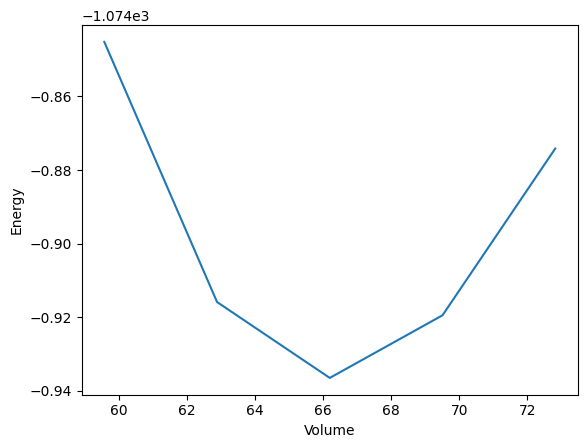

In [15]:
from jobflow import job, Response, Flow, run_locally

# set up QE PP env
os.environ["ESPRESSO_PSEUDO"] = f"{os.getcwd()}/espresso/pseudo"


@job
def get_ev_curve(structure: Atoms | MSONAtoms, strain_lst: list(float)):
    structures = generate_structures(structure, strain_lst=strain_lst)
    jobs = []
    volumes = []
    energies = []
    for istructure in range(len(strain_lst)):
        new_job = StaticQEMaker().make(structures[istructure])
        jobs.append(new_job)
        volumes.append(new_job.output.volume)
        energies.append(new_job.output.energy)
    return Response(
        replace=Flow(jobs, output={"energies": energies, "volumes": volumes})
    )


@job
def plot_energy_volume_curve_job(volume_lst: list(float), energy_lst: list(float)):
    plot_energy_volume_curve(volume_lst=volume_lst, energy_lst=energy_lst)


structure = bulk("Al", a=4.15, cubic=True)
relax = BaseQEMaker().make(structure=MSONAtoms(structure))
ev_curve_data = get_ev_curve(
    relax.output.structure, strain_lst=np.linspace(0.9, 1.1, 5)
)
# structure optimization job and (E, V) curve data job connected via relax.output
plot_curve = plot_energy_volume_curve_job(
    volume_lst=ev_curve_data.output["volumes"],
    energy_lst=ev_curve_data.output["energies"],
)
# (E, V) curve data job and plotting the curve job connected via ev_curve_data.output
qe_flow = [relax, ev_curve_data, plot_curve]
qe_fw = Flow(qe_flow)
# qe_flow is the QE flow that consists of the job for structural optimization, calculating the (E, V) curve data points and plotting the curve
run_locally(
    qe_fw, create_folders=True
)  # order of the jobs in the flow determined by connectivity

graph = to_mermaid(qe_fw, show_flow_boxes=True)
mm(graph)

And with using the `job.output` connectivity, the mermaid graph looks like:

In [16]:
mm(
    """
flowchart TD
    6883bfe0-2b20-49de-92df-c166d6f91dbc(base qe job) --> |output.structure| dfc9a5cd-fb91-4582-b6c6-c42b4c65cb83(get_ev_curve)
    dfc9a5cd-fb91-4582-b6c6-c42b4c65cb83(get_ev_curve) --> |'volumes', 'energies'| 92d14a25-bb90-4c86-b970-af05db90550e(plot_energy_volume_curve_job)
"""
)

## Submission to an HPC / Check pointing / Error handling
* Use the `jobflow` command `run_locally` to run jobs in serial with a simple job script
* Use `fireworks` and `jobflow-remote` to simplify and parallelize the submission of jobs, and allows for checkpointing
* Use [`custodian`](http://materialsproject.github.io/custodian/) error handling (not directly handled by `jobflow`), e.g. like in `atomate2`

## Data Storage / Data Sharing
Key data can be saved in a dedicated MongoDB-like database. This data can be validated with the help of
`pydantic`. The latter also allows a direct connection to Fast-API. The Materials Project data generation
relies on similar features. Direct calculation outputs will be saved on the compute machine. 
There are no dedicated mechanisms to save whole projects, but the database can be used to achieve this.

## Publication of the workflow
The `jobflow` infrastructure does not provide a dedicated platform for publishing a workflow currently. However, workflows related to computational materials science have been collected in the package `atomate2`. In addition, users can build their own package by relying on `jobflow` and share it as a new Python-based program. There are also additional materials science packages like [NanoParticleTools](https://github.com/BlauGroup/NanoParticleTools) or [QuAcc](https://github.com/Quantum-Accelerators/quacc) that rely on `jobflow`.